# Investigating dropped data packets
My team is building a centralized log collection service in AWS and we've found that some data packets are being dropped between our on-site logs server and the other end of a VPN tunnel. I'm hoping to use logs from both the on-site log server and a proxy server on the other end of the tunnel in order to learn more about why packets are being lost.

In [124]:
# Libraries
import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns

## Inspecting the data

In [125]:
# Read .csv files
delft_df = pd.read_csv('/home/welced12/Downloads/delft-syslog.csv')
proxy_df = pd.read_csv('/home/welced12/Downloads/proxy-syslog.csv')

In [126]:
delft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705209 entries, 0 to 705208
Data columns (total 7 columns):
No.            705209 non-null int64
Time           705209 non-null float64
Source         705209 non-null object
Destination    705209 non-null object
Protocol       705209 non-null object
Length         705209 non-null int64
Info           705209 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 37.7+ MB


In [127]:
proxy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388621 entries, 0 to 388620
Data columns (total 7 columns):
No.            388621 non-null int64
Time           388621 non-null float64
Source         388621 non-null object
Destination    388621 non-null object
Protocol       388621 non-null object
Length         388621 non-null int64
Info           388621 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 20.8+ MB


These dataframes contain a few pieces of information about the data packets being sent from delft to the proxy server, including a timestamp, a source ip address, destination ip address, protocol label, data packet length (size), and a field of additional 'Info'. Of particular interest in this case are the Time and Info fields.

In [128]:
delft_df.head(5)

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.0,10.1.80.32,10.4.15.15,Syslog,244,LOCAL0.INFO: Jun 28 15:36:00 10.1.80.254 %ASA-...
1,2,0.0,10.1.80.32,10.4.15.15,Syslog,227,LOCAL0.INFO: Jun 28 15:36:00 10.1.80.254 %ASA-...
2,3,0.0,10.1.80.32,10.4.15.15,Syslog,234,LOCAL0.INFO: Jun 28 15:35:59 10.0.0.1 %ASA-6-3...
3,4,0.0,10.1.80.32,10.4.15.15,Syslog,233,LOCAL0.INFO: Jun 28 15:36:00 10.1.80.254 %ASA-...
4,5,0.0,10.1.80.32,10.4.15.15,Syslog,233,LOCAL0.INFO: Jun 28 15:35:59 10.0.0.3 %ASA-6-3...


In [129]:
proxy_df.head(1500).tail(5)

,No.,Time,Source,Destination,Protocol,Length,Info
1495,2880,0.041,10.1.80.32,10.4.15.15,Syslog,229,LOCAL0.INFO: Jun 28 15:36:00 10.0.0.1 %ASA-6-3...
1496,2881,0.041,10.1.80.32,10.4.15.15,Syslog,233,LOCAL0.INFO: Jun 28 15:36:00 10.0.0.1 %ASA-6-3...
1497,2882,0.041,10.1.80.32,10.4.15.15,Syslog,245,LOCAL0.INFO: Jun 28 15:36:00 10.0.0.1 %ASA-6-3...
1498,2883,0.041,10.1.80.32,10.4.15.15,Syslog,220,LOCAL0.INFO: Jun 28 15:36:00 10.0.0.1 %ASA-6-3...
1499,2884,0.041,10.1.80.32,10.4.15.15,Syslog,213,LOCAL0.INFO: Jun 28 15:36:00 10.0.0.1 %ASA-6-3...


The Time field tells us how many seconds after some starting time t the packet was sent.

In [130]:
proxy_df.loc[0,'Info']

'LOCAL0.INFO: Jun 28 15:36:00 10.1.80.254 %ASA-6-302015: Built inbound UDP connection 3532848521 for sf-fw-outside-30:10.216.179.187/63360 (10.216.179.187/63360) to sf-campus-116:10.1.16.111/53 (10.1.16.111/53)\\\\n'

In [131]:
delft_df.loc[0,'Info']

'LOCAL0.INFO: Jun 28 15:36:00 10.1.80.254 %ASA-6-302015: Built inbound UDP connection 3532848521 for sf-fw-outside-30:10.216.179.187/63360 (10.216.179.187/63360) to sf-campus-116:10.1.16.111/53 (10.1.16.111/53)\\\\n'

The Info field conatins some additional information that's unique to this data packet. If a data packet is sent from delft, it should be received with the same 'Info' entry, so each log entry from the proxy server should have a matching pair in the logs from delft.

In this case, it will be useful to determine which of the packets sent from delft was received by the proxy.

## Working with the data
I want to add a column to the entries from delft saying whether or not they were received by the proxy.

In [132]:
# Convert the Info field into something more easily comparable at scale
delft_df['uid'] = [ 
    hashlib.sha1(x.encode('utf-8')).hexdigest() 
    for x in delft_df.Info.values 
]

proxy_df['uid'] = [ 
    hashlib.sha1(x.encode('utf-8')).hexdigest() 
    for x in proxy_df.Info.values 
]

For each of the entries from delft, determine whether that entry appears on the proxy server.

In [133]:
# Start by working with a subset
recvd_packets = [
    1 if txt in proxy_df.uid.values[:50000]
    else 0
    for txt in delft_df.uid.values[:50000]
]

In [134]:
# sanity check
sum(recvd_packets)

27016

Looks like we see evidence of dropped packets in this subset. The next thing I want to do is try and bin the packets by timestamp. I can then use each millisecond as a data point and see how many packets were sent during that millisecond and how many of those were dropped.

In [135]:
# Start by looking at first 50000 packets 
sent_df = delft_df.head(50000)
sent_df['received'] = recvd_packets
sent_df.head(10)

/home/welced12/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,No.,Time,Source,Destination,Protocol,Length,Info,uid,received
0,1,0.0,10.1.80.32,10.4.15.15,Syslog,244,LOCAL0.INFO: Jun 28 15:36:00 10.1.80.254 %ASA-...,323d24d285d97a330d95d984a35f04073dec3682,1
1,2,0.0,10.1.80.32,10.4.15.15,Syslog,227,LOCAL0.INFO: Jun 28 15:36:00 10.1.80.254 %ASA-...,a98fb036b75708dce0174b5849595af584456d4e,1
2,3,0.0,10.1.80.32,10.4.15.15,Syslog,234,LOCAL0.INFO: Jun 28 15:35:59 10.0.0.1 %ASA-6-3...,347376e945af7a70e2e14913de0ce47ca24ae736,1
3,4,0.0,10.1.80.32,10.4.15.15,Syslog,233,LOCAL0.INFO: Jun 28 15:36:00 10.1.80.254 %ASA-...,09bae3b8fb7847fc3e72bd9a3efb287764200c10,1
4,5,0.0,10.1.80.32,10.4.15.15,Syslog,233,LOCAL0.INFO: Jun 28 15:35:59 10.0.0.3 %ASA-6-3...,a0601f0a46dc94c13db457c8f03d978dbd92c73f,1
5,6,0.0,10.1.80.32,10.4.15.15,Syslog,234,LOCAL0.INFO: Jun 28 15:35:59 10.0.0.3 %ASA-6-3...,4a423788099294922ed22757f17c6b6ddc90aa00,1
6,7,0.0,10.1.80.32,10.4.15.15,Syslog,235,LOCAL0.INFO: Jun 28 15:35:59 10.0.0.3 %ASA-6-3...,ddb6ccafd410e369aac244ce6901b079449e79b7,1
7,8,0.0,10.1.80.32,10.4.15.15,Syslog,226,LOCAL0.INFO: Jun 28 15:35:59 10.0.0.1 %ASA-6-3...,fe02d388d47278d7a99208e848b902beb02b3984,1
8,9,0.0,10.1.80.32,10.4.15.15,Syslog,213,LOCAL0.INFO: Jun 28 15:35:59 10.0.0.1 %ASA-6-3...,4e66681345562e2d19ba1cb6d006e65e0639165e,1
9,10,0.0,10.1.80.32,10.4.15.15,Syslog,241,LOCAL0.INFO: Jun 28 15:35:59 10.0.0.1 %ASA-6-3...,95b1e55034b76b1254fb05ea80125cad4300eba3,1


In [136]:
# Group by timestamp, calculate traffic and drop rate each millisecond.
agg_df = sent_df[['Time','received']].groupby('Time').agg(['mean','count'])
agg_df.head(15)

received      
           mean count
Time                 
0.000  1.000000   119
0.001  1.000000   119
0.002  1.000000   123
0.003  1.000000   123
0.004  1.000000   120
0.005  1.000000    99
0.006  1.000000   121
0.007  1.000000   115
0.008  0.550000   120
0.009  0.434426   122
0.010  0.388430   121
0.011  0.800000   110
0.012  0.813008   123
0.013  0.796748   123
0.014  0.439024   123

Looks like the first few milliseconds saw no dropped packets, but packet loss did start occurring pretty quickly.

In [137]:
# Get ready to start plotting things.
agg_df.columns = agg_df.columns.droplevel()
agg_df = agg_df.reset_index()
agg_df.head(5)

,Time,mean,count
0,0.000,1.0,119
1,0.001,1.0,119
2,0.002,1.0,123
3,0.003,1.0,123
4,0.004,1.0,120


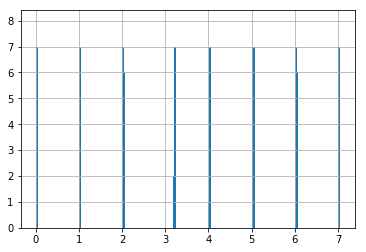

In [138]:
# Histogram when packets are being sent.
agg_df['Time'].hist(bins=1000)
plt.show()

It looks like packets are localized to particular timestamps. I suspect this means that delft is building a list of packets in a buffer and then sending everything in the buffer each second. Let's take a closer look at the spikes.

In [139]:
# Rename columns so that they make more sense on a plot
agg_df.rename(index=str, 
              columns={'mean':'received rate',
                                  'count':'packets sent'},
              inplace=True)

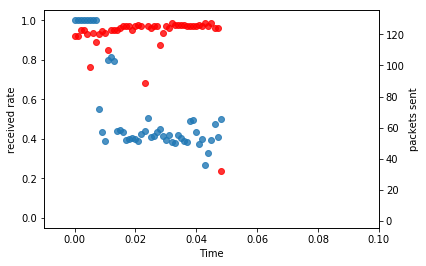

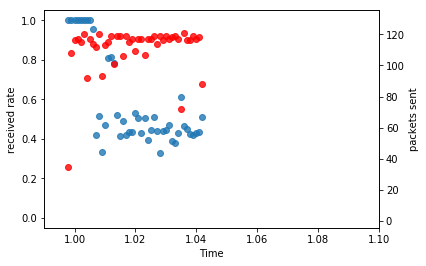

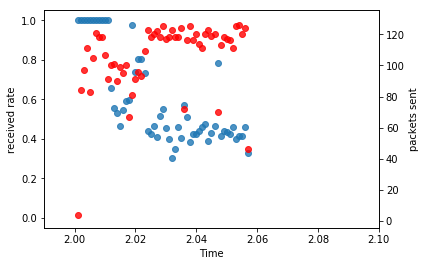

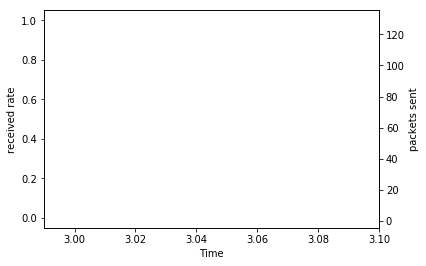

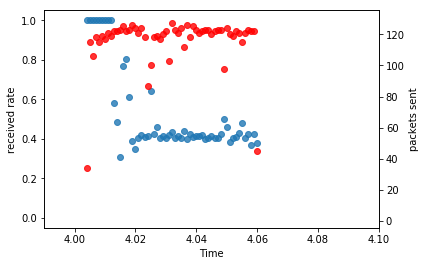

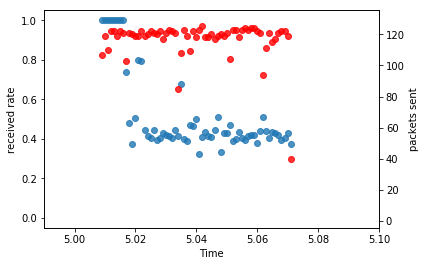

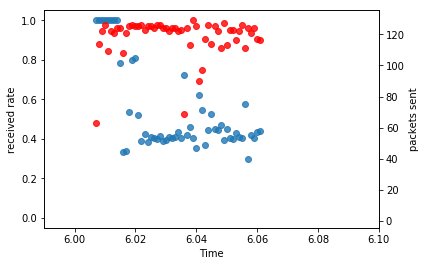

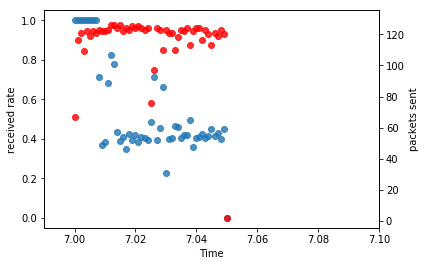

In [140]:
# Create a plot for each of the bursts in this data subset
for i in range(8):
    fig, ax = plt.subplots()
    ax = sns.regplot('Time', 'received rate', agg_df, fit_reg=False)
    ax2 = ax.twinx()
    sns.regplot('Time', 'packets sent', agg_df, fit_reg=False, ax=ax2, color='red')
    ax.set(xlim=(i-0.01,i+0.1))
    plt.show()

These plots all show very similar behavior with respect to the number of packets being sent and the packet drop rate. It looks like the packets are consistently being sent at a rate of about 120 packets per millisecond. At the beginning of each burst, all of those packets are being received, but after 10 milliseconds or so, packets start being lost.

## Analysis and Conclusions

This exploration has provided us with valuable information. We know that data packets are being buffered and sent in batches every second, at a consistent rate. We know that the first packets sent from each buffer are received, at least for a short time, but the length of that time varies. After that, about half of the packets are lost. We also know that this behavior is very consistent, at least over the few seconds of this dataset.

What this indicates to me is that whatever process is receiving the data packets on the proxy server is unable to handle the volume of data packets being sent. The first few packets are received without issue, but this process is quickly overloaded, causing the observed packet loss. Our next step is to investigate the process that should be receiving the packets.